# Module 2: Water flow in soil (no root uptake) 

*by Daniel Leitner, Andrea Schnepf, Valentin Couvreur*

## Theory


Water flow in soil is described by the Richards equation, which is given by 
\begin{eqnarray} \label{eq:rich1d}
\frac{\partial \theta}{\partial t}=  \nabla \cdot\left( K_c(\theta) \left( \nabla \psi_s - e_3 \right) \right),
\end{eqnarray}
in three dimesnions, where $\theta$ is the water content [1], $K_c$ is the hydraulic conductivity [cm / day], and  $\psi_s$ is the soil matric potential [cm]. 


The relationship between soil water potential and water content is generally described by the water retention curve. In the following we will use the Mualem Van Genuchten model (Van Genuchten, 1980) to describe this curve specifying the soil moisture characteristic of specific soils. 


## Benchmarks


Benchmarks for water movement in soil were developed by Vanderborght et al. (2005). In the following we will shortly describe two relevant benchmarks and implement their analytical solutions within the notebook. The derivation is given in Vanderborght et al. (2005).  

In the following benchmarks soil properties are described by the Mualem Van Genuchten model (Van Genuchten, 1980). We will first import libraries and define some auxiliary functions:

In [3]:
import numpy as np
from scipy import optimize
from scipy import integrate
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from math import * 
import os

In [4]:
# Mualem - van Genuchten model, equations from van Genuchten, MT (1980)

# class containing the van genuchten parameters
class Parameters:
    def __init__(self, R, S, alpha, n, Ksat):
        self.theta_R = R
        self.theta_S = S        
        self.alpha = alpha # [1/cm]         
        self.n = n
        self.m = 1.-1./n
        self.Ksat = Ksat       

# returns the volumetric water content at a given pressure head  according to the van genuchten model (Eqn 21)
def water_content(h, sp):
    return sp.theta_R + (sp.theta_S-sp.theta_R)/pow(1. + pow(sp.alpha*abs(h),sp.n),sp.m)

# returns pressure head at a given volumetric water content according to the van genuchten model
def pressure_head(theta, sp): 
    theta = min(theta,sp.theta_S) # saturated water conent is the maximum 
    return - pow( pow( (sp.theta_S - sp.theta_R)/(theta - sp.theta_R), (1./sp.m))-1., 1./sp.n) / sp.alpha

# returns the effective saturation according to the van genuchten model (dimensionless water content, Eqn 2)
def effective_saturation(h,sp):
    h = min(h,0) # pressure head is negative, zero the maximum
    theta = water_content(h,sp)
    se = (theta-sp.theta_R)/(sp.theta_S-sp.theta_R)
    return se

# returns the hydraulic conductivity according to the van genuchten model (Eqn 8)
def hydraulic_conductivity(h,sp):
    se = effective_saturation(h,sp) 
    K = sp.Ksat*sqrt(se)*( (1. - pow(1. - pow(se, 1. / sp.m),sp.m)) ** 2 )
    return K 

# returns the specific moisture storage according to the van genuchten model
def specific_moisture_storage(h,sp):
    C = -sp.alpha*sp.n*np.sign(h)*(1. / sp.n - 1.) * pow(sp.alpha*abs(h), sp.n-1.) * (sp.theta_R-sp.theta_S) * pow(pow(sp.alpha*abs(h),sp.n) + 1., 1./sp.n-2.)
    return C

# returns the water diffusivity (Eqn 11)
def water_diffusivity(TH, theta_i, theta_sur, sp):
    theta = TH * (theta_i - theta_sur) + theta_sur
    Se = (theta - sp.theta_R) / (sp.theta_S - sp.theta_R)
    m = sp.m
    D = (1 - m) * sp.Ksat / (sp.alpha * m * (sp.theta_S - sp.theta_R)) * pow(Se, 0.5 - 1. / m) * (pow(1 - pow(Se, 1. / m), -m) + pow(1 - pow(Se, 1 / m), m) - 2)
    return D

The benchmarks use the following soil types (from the soil catalogue of Hydrus 1D), the parameters are $\theta_r$, $\theta_s$, $\alpha$, $n$, and $K_s$:

In [5]:
sand = Parameters(0.045, 0.43, 0.15, 3, 1000) 
loam = Parameters(0.08, 0.43, 0.04, 1.6, 50)
clay = Parameters(0.1, 0.4, 0.01, 1.1, 10)

### Benchmark M2.1: Infiltration in an initially dry soil


We consider three scenarios: sand, loam, and clay. All soil profiles are 200 cm deep, an initially the soil matric potential is -400 cm everywhere. 

At top boundary we prescribe an influx of 100 cm/day if the soil matric potential is negative ($\psi_s(z=0) < 0$ cm), else we prescribe full saturation as Dirichlet boundary condition ($\psi_s(z=0)= 0$ cm). At the bottom free drainage boundary conditions is used.

The analytical solution of Benchmark M2.1 is calculated by the following code and reproduces Figure 4abc from Vanderborght et al. (2005). 

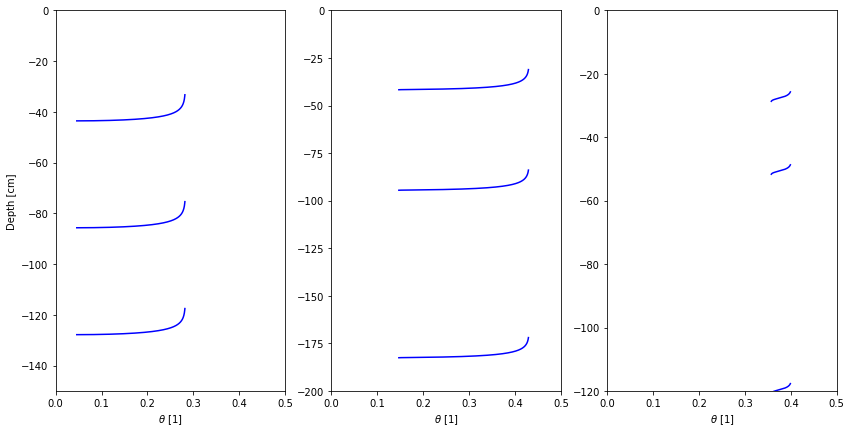

In [6]:
t_a2 = [0.1, 0.2, 0.1] 
x_aa = [43, 41, 27.5] # TODO how to choose reference water content and its position ?    
tv=[ [0.1, 0.2, 0.3], [0.2, 0.5, 1.0], [0.1, 0.2, 0.5] ] # time values (days)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 7))
ax = [ax1,ax2,ax3]
theta3 = []
z3 = []

for i, soil in enumerate([sand, loam, clay]): # make three subplots
        
    if soil==sand:
        theta_sur = 0.2824 # ? TODO where does this value come from?
    else:
        theta_sur = soil.theta_S            
    theta_i = water_content(-400,soil);
        
    K_sur = hydraulic_conductivity( pressure_head(theta_sur,soil), soil);
    K_i = hydraulic_conductivity(-400, soil)
    psi = lambda theta: pressure_head(theta,soil)
    K = lambda psi: hydraulic_conductivity(psi,soil)
    Dw = lambda psi: K(psi)/(specific_moisture_storage(psi,soil))            
    F = lambda theta:  Dw(psi(theta)) / ( (K_sur - K_i)*(theta - theta_i) - (K(psi(theta)) - K_i)*(theta_sur - theta_i) ) 
    
    theta_a = (theta_sur+theta_i)/2
    theta_ = np.linspace (theta_i+1e-3,theta_sur-1e-3,1000)

    delta_eta = np.zeros(len(theta_),)
    for j in range(0,len(theta_)):
        ans, err = integrate.quad(F,theta_[j],theta_a)
        delta_eta[j] = ans
    
    delta_eta = delta_eta * (theta_sur - theta_i)
    x_a = x_aa[i]
    t_a = t_a2[i]        
    eta_a = x_a - (K_sur-K_i)/(theta_sur - theta_i)*t_a
    eta = delta_eta + eta_a

    # finally, plot the thing    
    for j in range(0,len(tv[0])):
        t = tv[i][j]
        x = eta  + (K_sur - K_i) * t / (theta_sur - theta_i);
        ax[i].plot(theta_,-x,'b-')
        theta3.append(theta_) # remember results for evaluation
        z3.append(-x)
    ax[i].set_xlabel(r'$\theta$ [1]')
    ax[i].set_xlim(0,0.5)

ax1.set_ylabel('Depth [cm]')
ax1.set_ylim(-150,0)
ax2.set_ylim(-200,0)
ax3.set_ylim(-120,0)
plt.show()

### Benchmark M2.2: Transient evaporation from a soil profile


For Benchmark M2.2 we consider four scenarios: (1) sand, (2) loam, (3) loam, and (4) clay, all profiles with a depth of 100 cm. Initially, we assume a soil matric potential of -40 cm for scenario (1) and -200 cm for all other soils. 

At top we choose an eflux of 0.1 cm/day for scenario (1) and (2), and 0.3 cm/day for (3) and (4), if the water soil potential is higher than a critical value $\psi_s(z=0)>-10000$ cm. If it is lower, we set the matric potential to the critical value with a Dirchlet boundary condition, i.e. $\psi_s(z=0) = -10000$ cm. At the bottom we assume no flux.

The analytical solution of this benchmark is calculated by the following code and reproduces Figure 5abcd from Vanderborght et al. (2005). 


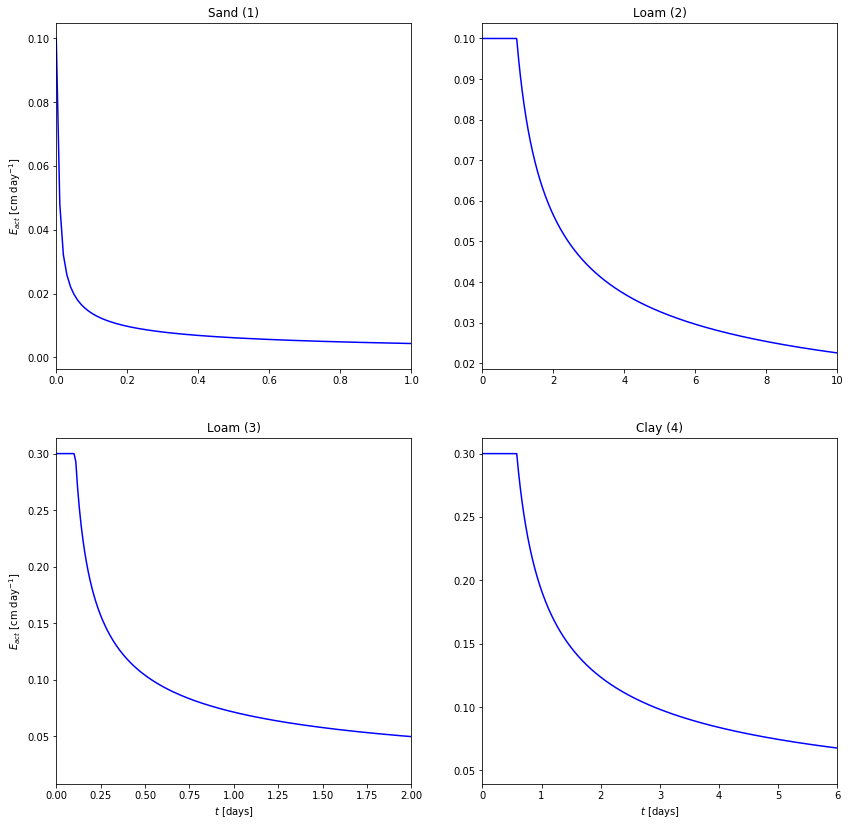

In [7]:
jwpot_ = [-0.1, -0.1, -0.3, -0.3] # potential eflux (cm/day)
head_i_ = [-40,-200,-200,-200] # initial soil matric potential (cm)

N = 1000
y = np.zeros((N,4))
t = np.linspace(0,10,N) # days

for i,soil in enumerate([sand, loam, loam, clay]):  
    
    head_i = head_i_[i]
    theta_i = water_content(head_i,soil) # initial theta  
    theta_sur = water_content(-10000,soil) # critical vaule 
    jwpot = jwpot_[i]      
    
    dw = lambda TH: water_diffusivity(TH,theta_i, theta_sur, soil)    
    int_dw, err = integrate.quad(dw,0,1)    
  
    theta_dw = lambda TH: TH*water_diffusivity(TH,theta_i, theta_sur, soil)       
    int_theta_dw, err = integrate.quad(theta_dw,0,1)
    beta = pow(int_theta_dw/int_dw,2) # Eqn 43

    fun_dw = lambda TH: pow(1-TH*beta,2)*dw(TH)
    alpha, err = integrate.quad(fun_dw,0,1)
    alpha /= int_dw  # Eqn 42

    mu = ( 3*beta*(1+sqrt(1-(14/9)*(1-alpha/pow(1-beta,2)) ) ) ) / ( 2*(1-beta)*(alpha/pow(1-beta,2)-1) ) # Eqb 41
    sw = lambda theta_sur, theta_i: (theta_i-theta_sur)*sqrt((4/mu)*int_dw) # Eqn 39  
    tdash = (sw(theta_sur, theta_i)*sw(theta_sur, theta_i)) / (4*jwpot*jwpot) # Eqn 44
    tpot =  (sw(theta_sur, theta_i)*sw(theta_sur, theta_i)) / (2*jwpot*jwpot) # Eqn 45
    jw = lambda t: (t<tpot)*jwpot+(t>=tpot)*sw(theta_sur, theta_i)/(2*sqrt(abs(tdash+t-tpot))) # eq 46 & 47

    y[:,i] = list(map(jw,t))  # evaluate

# prepare plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 14))    
ax1.plot(t,abs(y[:,0]),'b')
ax1.set_ylabel('$E_{act}$ [cm day$^{-1}$]')
ax1.set_xlim(0,1)
ax1.set_title("Sand (1)")
ax2.plot(t,abs(y[:,1]),'b')
ax2.set_xlim(0,10)
ax2.set_title("Loam (2)")
ax3.plot(t,abs(y[:,2]),'b')
ax3.set_xlabel('$t$ [days]')
ax3.set_ylabel('$E_{act}$ [cm day$^{-1}$]')
ax3.set_xlim(0,2)
ax3.set_title("Loam (3)")
ax4.plot(t,abs(y[:,3]),'b')
ax4.set_xlabel('$t$ [days]')
ax4.set_xlim(0,6)
ax4.set_title("Clay (4)")
plt.show()

t4 = t # remember results for later
y4 = abs(y)

## Comparison to numerical solutions

Benchmark M2.1 and M2.2 was evaluated for *Macro*, *Hydrus1D*, *Swap*, *Marthe*, and *Wave* in Vanderborght et al. 2005. 

We validate additional numerical codes by solving the benchmarking problems. In the following we link to notebooks, containing all or some of above benchmarks: 

* [Dumux](Soil water flow - Dumux.ipynb)


There are many softwares solving Richards equation. What are the most important features, and which softwares are most suitable for a specific purpose. 

* Availability and license 
* Dimensions: 1D, 1D axial symmetric, 3D
* Mass conservation
* Parallel computing
* Support of unstructured meshes and adaptive refinement


### Benchmark M2.1

For an automatic comparison of the numerical results, save the results in a text file with two lines containing comma separated depth values (cm) in the first line, and pressure head (cm) in the second for each infiltration scenario (i.e. 2 * 3 (time points) * 3 (scenarios) lines), and copy it to the folder /soil_water_flow/b3/simulatorname.

dumux1d_b3 :



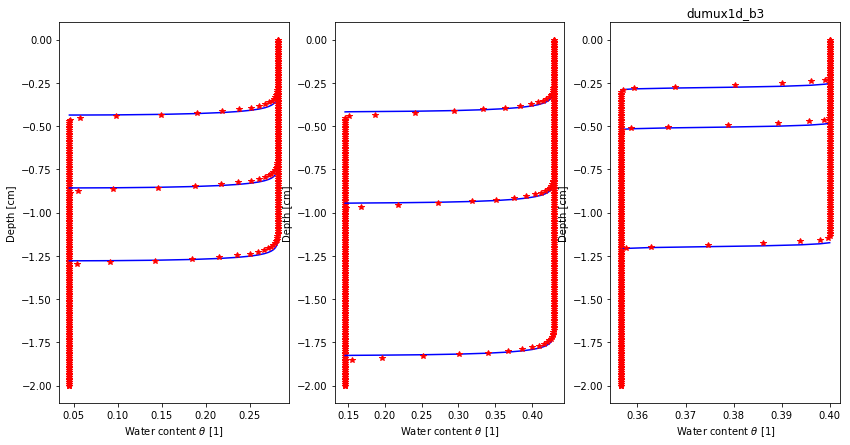

dumux3d_b3 :



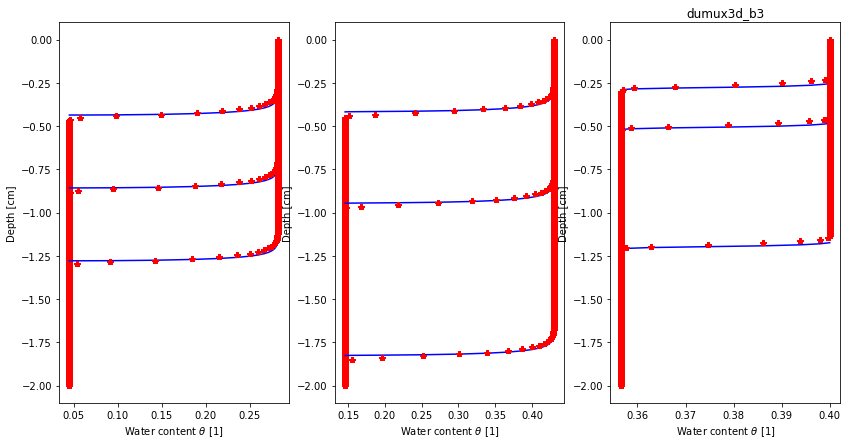

In [8]:
for dirname, dirnames, filenames in os.walk('soil_water_flow/b3/.'):
    filenames.sort()
    for i,f in enumerate(filenames):    
        
        print(f,":\n")        
        data = np.loadtxt('soil_water_flow/b3/'+f,delimiter=',')        
        fig, ax = plt.subplots(1, 3, figsize=(14, 7))       
        
        for j in range(0,3): # axis
            for k in range(0,3):                
                z = data[2*(3*j+k), :]
                theta = data[2*(3*j+k)+1, :]   
                
                interp = interp1d(theta3[3*j+k], z3[3*j+k]/100,  kind='linear', fill_value='extrapolate' ) 
                z_a = interp(theta)
            
                ax[j].plot(theta,z_a,'b') # analytical solution
                ax[j].plot(theta,z,'r*') # numeric solution                           
            
            ax[j].set_xlabel("Water content $\\theta$ [1]")
            ax[j].set_ylabel("Depth [cm]")                               
            
        plt.title(f)                           
        plt.show()

### Benchmark M2.2

For an automatic comparison of the numerical results, save the results in a text file with two lines containing comma separated time points (days) in the first line, and actual evaporation rate (cm day-1) in the second for each scenario, with low and high resolution (i.e. 4 (scenarios) * 2 (resolutions) lines), located in the folder /soil_water_flow/b4/simulatorname.

dumux1d_b4 :

R² = -1.5551598898878063 ( N = 1447 )

R² = 0.8850883109801855 ( N = 1447 )

R² = 0.724399629354137 ( N = 1447 )

R² = 0.9449481507943871 ( N = 1447 )



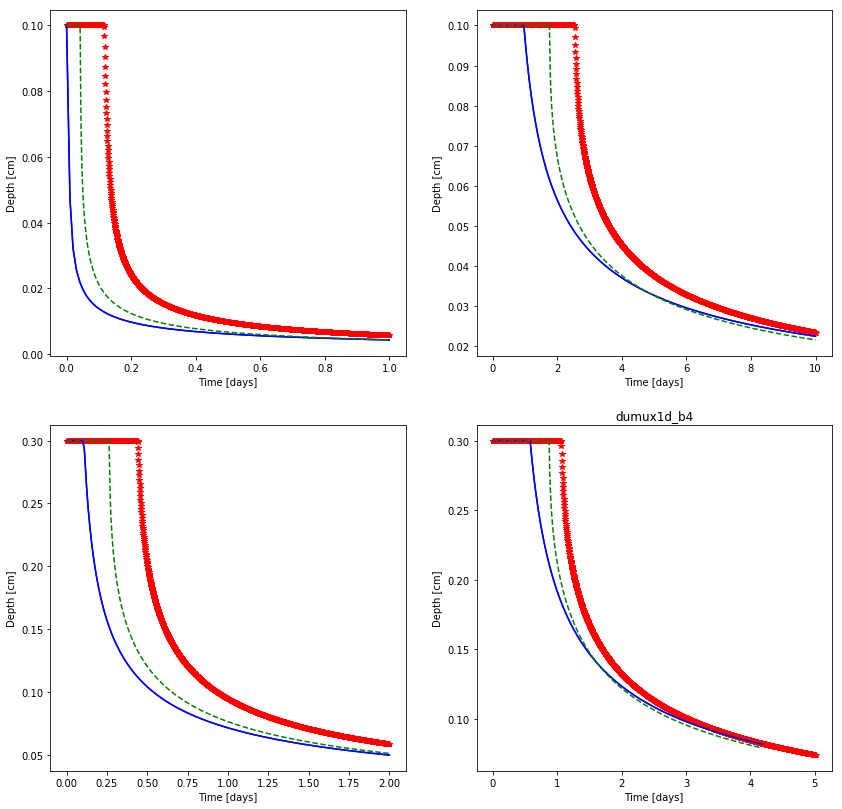

dumux3d_b4 :

R² = -9.450700086903403 ( N = 1447 )

R² = 0.5112811937823041 ( N = 1447 )

R² = -0.13208063158454086 ( N = 1447 )

R² = 0.6134564096815165 ( N = 1447 )



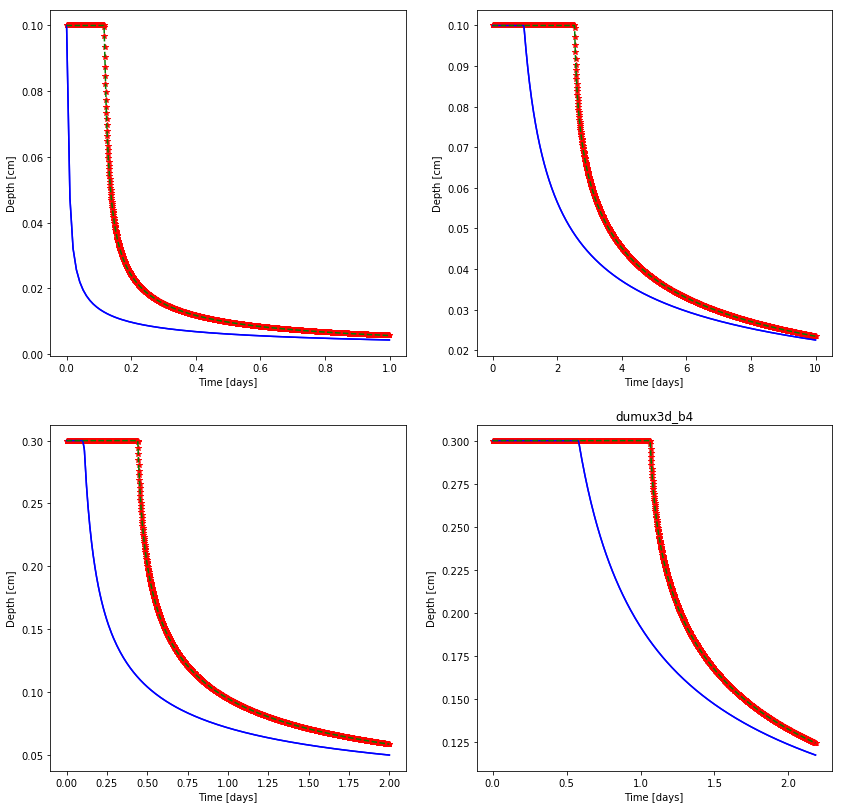

In [9]:
for dirname, dirnames, filenames in os.walk('soil_water_flow/b4/.'):
    filenames.sort()
    for i,f in enumerate(filenames):    
        
        print(f,":\n")        
        data = np.loadtxt('soil_water_flow/b4/'+f,delimiter=',')        
        fig, ax = plt.subplots(2, 2, figsize=(14, 14))       
        
        for j in range(0,8): # 0-3 low res, 4-7 high res
                
            t = data[2*j, :]
            eva = data[2*j+1, :]                   
            j_ = j % 4                            
            
            interp = interp1d(t4, y4[:,j_],  kind='linear', fill_value='extrapolate' ) 
            eva_a = interp(t)
            ax[int(j_/2),j_%2].plot(t,eva_a,'b') # analytical solution                                                                                              
            ax[int(j_/2),j_%2].set_xlabel("Time [days]")
            ax[int(j_/2),j_%2].set_ylabel("Depth [cm]")     
            
            if j>3: # R² values for higher discretizations
                n = len(eva) # calculate R^2
                r = 1 - ( np.sum(np.square(eva_a-eva)) / (np.sum(np.square(eva_a))-np.square(np.sum(eva_a))/n) )    
                print("R² =", r ,"( N =", n, ")\n")                
                ax[int(j_/2),j_%2].plot(t,eva,'g--') # numeric solution 
            else:
                ax[int(j_/2),j_%2].plot(t,eva,'r*') # numeric solution 
            
        plt.title(f)                           
        plt.show()

## References

Vanderborght, J and Kasteel, R and Herbst, M and Javaux, M and Thiery, D and Vanclooster, M and Mouvet, C and Vereecken, H (2005) A set of analytical benchmarks to test numerical models of flow and transport in soils. *Vadose Zone Journal*, 4(1):206-221

Van Genuchten, MT (1980) Closed-form equation for predicting the hydraulic conductivity of unsaturated soils. *Soil Science Society of America Journal* 44(5):892-898
